[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AlphaLabsUY/recsys/main)

[![Colab](https://camo.githubusercontent.com/52feade06f2fecbf006889a904d221e6a730c194/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667
)](https://colab.research.google.com/github/AlphaLabsUY/recsys/blob/main/recommendation_system_instacart.ipynb?authuser=1)


In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install implicit umap-learn -q
else:
    %matplotlib notebook

In [2]:
import os
import requests
import zipfile

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from umap import UMAP
from scipy.sparse import csr_matrix

os.environ["OPENBLAS_NUM_THREADS"] = "1"



# Get and load Data Set
The original datata set is provided by the followin kaggle competition [instacart market basket analysis](https://www.kaggle.com/c/instacart-market-basket-analysis/overview) 


In [3]:
def download_dataset():
    url = "https://www.dropbox.com/s/p2w4hql4qjsm0a2/instacart.zip?dl=1"

    path = 'data'
    file = 'instacart.zip'
    if not os.path.exists(path):
        os.makedirs(path)

    if not os.path.exists(f'{path}/{file}'):
        r = requests.get(url, stream = True)
        with open(f"{path}/{file}", "wb") as f:
            for chunk in r.iter_content(chunk_size = 1024):
                if chunk:
                    f.write(chunk)
        with zipfile.ZipFile(f"{path}/{file}", 'r') as zip_ref:
            zip_ref.extractall(path)

download_dataset()

In [4]:
dataset_path = "./data/" 

orders_path = os.path.join(dataset_path, "orders.csv")
product_path = os.path.join(dataset_path, "products.csv")
orders_product_prior_path = os.path.join(dataset_path, "order_products__prior.csv")
orders_product_train_path = os.path.join(dataset_path, "order_products__train.csv")
departments_path = os.path.join(dataset_path, "departments.csv")
aisles_path = os.path.join(dataset_path, "aisles.csv")

In [5]:
products_dtypes = {
    'product_id': np.int32, 
    'product_name': str, 
    'aisle_id': np.uint8, 
    'department_id': np.uint8
}

orders_dtypes = {
    'order_id': np.int32, 
    'user_id': np.int32, 
    'eval_set': str, 
    'order_number': np.uint8, 
    'order_dow': np.uint8, 
    'order_hour_of_day': np.uint8, 
    'days_since_prior': np.float32
}

order_product_dtypes = {
    'order_id': np.int32, 
    'product_id': np.int32, 
    'add_to_cart_order': np.uint8,
    'reordered': np.uint8
}

orders = pd.read_csv(orders_path, dtype=orders_dtypes)
products = pd.read_csv(product_path, dtype=products_dtypes)
orders_product_prior = pd.read_csv(orders_product_prior_path, dtype=order_product_dtypes)
orders_product_train = pd.read_csv(orders_product_train_path, dtype=order_product_dtypes)
departments = pd.read_csv(departments_path)
aisles = pd.read_csv(aisles_path)

# Exploratory Data Analysis

## Departments

In [6]:
departments.shape

(21, 2)

In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## Aisles

In [8]:
aisles.shape

(134, 2)

In [9]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## Products

In [10]:
products = products.merge(departments, on='department_id', how='left')

In [11]:
products.shape

(49688, 5)

In [12]:
products.head()

,product_id,product_name,aisle_id,department_id,department
0,1,Chocolate Sandwich Cookies,61,19,snacks
1,2,All-Seasons Salt,104,13,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen
4,5,Green Chile Anytime Sauce,5,13,pantry


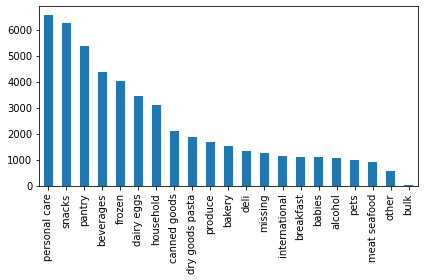

In [13]:
f, ax = plt.subplots()
products['department'].value_counts().plot(kind='bar', ax=ax)
f.tight_layout()

## Orders


In [14]:
orders.shape

(3421083, 7)

In [15]:
orders['order_id'].nunique()

3421083

In [16]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [17]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [18]:
orders["eval_set"].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

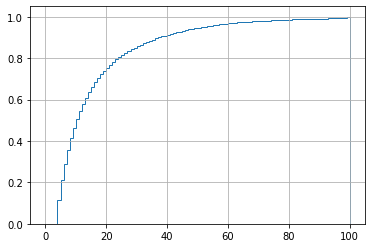

In [19]:
f, ax = plt.subplots()
orders.groupby('user_id')['order_number'].max().hist(bins=100,
                                                     range=(0,100),
                                                     ax=ax,
                                                     density=True,
                                                     cumulative=True,
                                                     histtype='step', )

categoras por hora

## Users

In [20]:
users = orders['user_id'].unique()
print(f'Total users: {users.shape[0]:,}')

Total users: 206,209


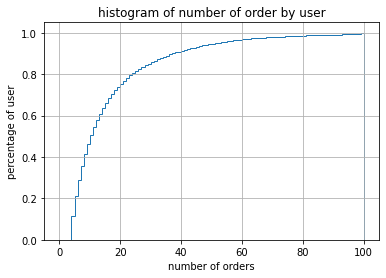

In [21]:
f, ax = plt.subplots()
orders.groupby("user_id")['order_number'].max().hist(bins=100,
                                                     range=(0,100),
                                                     density=True,
                                                     cumulative=True,
                                                     histtype='step',
                                                     ax=ax
                                                    )
ax.set(xlabel='number of orders',
       ylabel='percentage of user',
       title='histogram of number of order by user');


## Order/Product

In [22]:
orders_product_prior.shape

(32434489, 4)

In [23]:
orders_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


The product coverage

In [24]:
orders_product_prior['product_id'].nunique() / products.shape[0]

0.9997786185799388

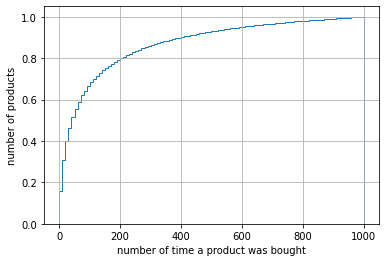

In [25]:
ax = (
    orders_product_prior['product_id']
    .value_counts()
    .hist(bins=100, range=(0,1000), density=True, cumulative=True, histtype='step')
)
ax.set(xlabel='number of time a product was bought',
       ylabel='number of products');

## Overview

In [26]:
full_dataset = (orders_product_prior
                .merge(orders, on='order_id')
                .merge(products, on='product_id')
               # .merge(departments, on='department_id')
               )

In [27]:
full_dataset

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3265099,43492,3,0,111311,prior,2,3,10,5.0,Gourmet Burger Seasoning,104,13,pantry
32434485,3361945,43492,19,0,142932,prior,25,3,10,5.0,Gourmet Burger Seasoning,104,13,pantry
32434486,3267201,33097,2,0,183867,prior,19,3,18,3.0,Piquillo & Jalapeno Bruschetta,81,15,canned goods
32434487,3393151,38977,32,0,79056,prior,1,4,13,NaN,Original Jerky,100,21,missing


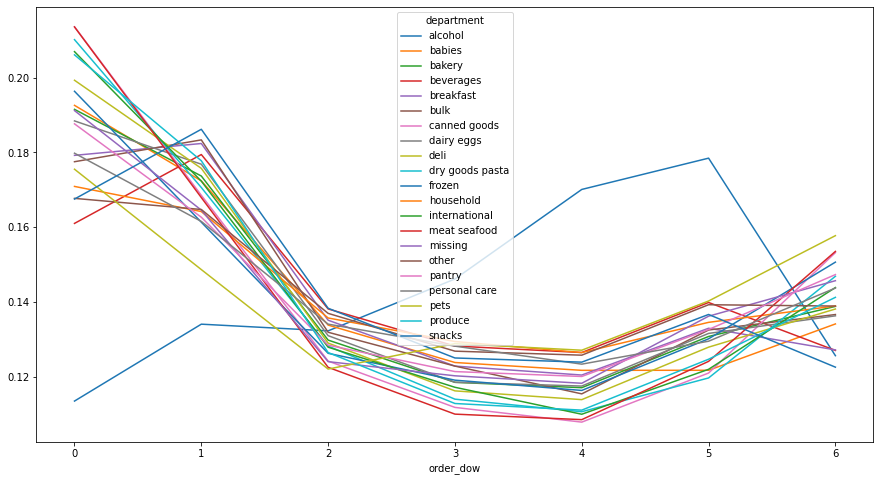

In [28]:
product_by_dow = full_dataset.pivot_table(index='order_dow',
                                          columns='department',
                                          values='product_id',
                                          aggfunc='count', )
product_by_dow /= product_by_dow.sum()

f, ax = plt.subplots(figsize=(15,8))
product_by_dow.plot(ax=ax)

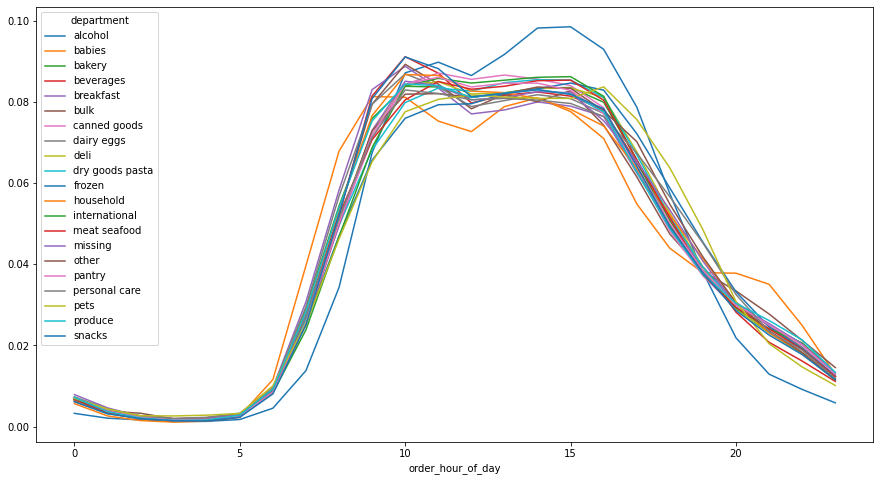

In [29]:
product_by_hour = full_dataset.pivot_table(index='order_hour_of_day',
                                           columns='department',
                                           values='product_id',
                                           aggfunc='count', )
product_by_hour /= product_by_hour.sum()


f, ax = plt.subplots(figsize=(15,8))
product_by_hour.plot(ax=ax)

In [30]:
### uniques

### Key User/Item Distributions

### User/Item Re-Purchases

### Most Popular

In [31]:
full_dataset['product_name'].value_counts(normalize=True)[:30]

Banana                                  0.014570
Bag of Organic Bananas                  0.011699
Organic Strawberries                    0.008161
Organic Baby Spinach                    0.007459
Organic Hass Avocado                    0.006585
Organic Avocado                         0.005451
Large Lemon                             0.004707
Strawberries                            0.004407
Limes                                   0.004336
Organic Whole Milk                      0.004252
Organic Raspberries                     0.004226
Organic Yellow Onion                    0.003497
Organic Garlic                          0.003385
Organic Zucchini                        0.003232
Organic Blueberries                     0.003085
Cucumber Kirby                          0.003000
Organic Fuji Apple                      0.002763
Organic Lemon                           0.002705
Apple Honeycrisp Organic                0.002621
Organic Grape Tomatoes                  0.002598
Seedless Red Grapes 

In [32]:
full_dataset['department'].value_counts(normalize=True)

produce            0.292260
dairy eggs         0.166922
snacks             0.089027
beverages          0.082940
frozen             0.068952
pantry             0.057827
bakery             0.036282
canned goods       0.032930
deli               0.032411
dry goods pasta    0.026719
household          0.022774
breakfast          0.021877
meat seafood       0.021857
personal care      0.013785
babies             0.013066
international      0.008301
alcohol            0.004739
pets               0.003013
missing            0.002132
other              0.001119
bulk               0.001066
Name: department, dtype: float64

# Feature Engineering


Split order into prior and train set

In [33]:
orders_prior = orders[orders["eval_set"] == "prior"]
orders_train = orders[orders["eval_set"] == "train"]

print(f'Number of unique user in prior: {len(orders_prior["user_id"].unique())}')
print(f'Number of unique user in train: {len(orders_train["user_id"].unique())}')

Number of unique user in prior: 206209
Number of unique user in train: 131209


Get full list of user_id / product_id

In [34]:
user_product_prior = (
    orders_product_prior[['order_id', 'product_id']]
    .merge(orders[['user_id', 'order_id']], on='order_id')
    .drop(columns=['order_id'])
)

user_product_train = (
    orders_product_train[['order_id', 'product_id']]
    .merge(orders[['user_id', 'order_id']], on='order_id')
    .drop(columns=['order_id'])
)

In [35]:
user_product_prior.head()

,product_id,user_id
0,33120,202279
1,28985,202279
2,9327,202279
3,45918,202279
4,30035,202279


In [36]:
user_product_prior.shape

(32434489, 2)

In [37]:
user_product_train.shape

(1384617, 2)

In [38]:
class SparseTransformer:
    """Convert user-item dataset into a sparse matrix"""
    def __init__(self):
        self.users = None
        self.products = None
        self.shape = None
    
    def _sparse_matrices(self, users, products, values = None):
        
        if not values:
            values = np.ones(len(users))
        
        row_index = users
        col_index = products

        sparse_user_item = \
            csr_matrix((values, (row_index, col_index)), shape=self.shape)
    
        return sparse_user_item

    def fit(self, users, products):
        self.shape = (np.max(users) + 1, np.max(products) + 1)
        return self
    
    def transform(self, users, products):
        return self._sparse_matrices(users, products)
    
    def fit_transform(self, users, products):
        return self.fit(users, products).transform(users, products)

In [39]:
data_model = SparseTransformer().fit(users=user_product_prior['user_id'],
                                     products=user_product_prior['product_id'])

sparse_user_item_prior = data_model.transform(user_product_prior['user_id'],
                                              user_product_prior['product_id'])

In [40]:
sparse_user_item_prior = (bm25_weight(sparse_user_item_prior, B=0.9) * 5).tocsr()
sparse_item_user_prior = sparse_user_item_prior.T.tocsr()


sparse_user_item_prior.shape

(206210, 49689)

# Modeling

## Random Model (base line)

In [41]:
class RandomModel():
    def __init__(self):
        self.products = None
    
    def train(self, products):
        self.products = np.asarray(products)
        return self

    def recommend(self, size=(1,10)):
        return np.random.choice(self.products, size=size, replace=False)

In [42]:
random_model = RandomModel().train(products.index.tolist())

## Alternating Least Squares (ALS) model

In [43]:
model_user_item = AlternatingLeastSquares(factors=128,
                                          random_state=42,
                                          iterations=10,
                                          calculate_training_loss=True,
                                         )
model_user_item.fit(item_users=sparse_item_user_prior)

# Evaluation

## Random Model

In [44]:
random_rec = random_model.recommend()

products.loc[random_rec[0].tolist(), :]

,product_id,product_name,aisle_id,department_id,department
48085,48086,Black Forest Ham,96,20,deli
30232,30233,Organic Large Brown Grade AA Cage Free Eggs,86,16,dairy eggs
26125,26126,Moisturizing Yuzu Shower Gel,25,11,personal care
27326,27327,Habanero Peppers,83,4,produce
2071,2072,Psyllium Husks Veg Caps 625 Mg,70,11,personal care
10834,10835,Doubleshot Energy Coffee Energy Coffee Beverage,26,7,beverages
41814,41815,Ham & Turkey Breast Sub Kit,96,20,deli
1365,1366,Splash Berry Blend Juice,98,7,beverages
47277,47278,Roasted Turkey With Garlic Mashed Cauliflower,38,1,frozen
13594,13595,337 Cabernet Sauvignon Wine,28,5,alcohol


## ALS Model

In [45]:
user_id = 12221

The following tabla show the most frequent products bought by the user_id

In [46]:
user_prod_freq = (
    user_product_prior
    .loc[user_product_prior['user_id'] == user_id, 'product_id']
    .value_counts()
    .iloc[:20]
)

products.loc[user_prod_freq.index.to_list(), :]

,product_id,product_name,aisle_id,department_id,department
39275,39276,Bananas,24,4,produce
1117,1118,Ginger Chia Kombucha,31,7,beverages
29142,29143,L'Oréal® Paris Advanced Haircare Total Repair ...,22,11,personal care
18264,18265,Hello I'm A Handful Pretzel Bites,45,19,snacks
26209,26210,Almond Gold Bar,45,19,snacks
3819,3820,Double Chocolate Flavor Reduced Calorie Puddin...,71,16,dairy eggs
20119,20120,DeTox Caffeine Free Organic Herbal Tea Bags,94,7,beverages
28745,28746,On The Go Ice Raspberry,90,7,beverages
16797,16798,Chicken Breast Grilled Strips,7,12,meat seafood
19057,19058,"Lil' Pastas Ravioli, Cheese and Spinach",92,18,babies


### User recommendation

In [47]:
recommendation = model_user_item.recommend(user_id, sparse_user_item_prior, N=20)

products.loc[[k[0] for k in recommendation], :]

,product_id,product_name,aisle_id,department_id,department
311,312,Juicing Carrots,83,4,produce
47626,47627,Salsa Ranch Yogurt Dressing,89,13,pantry
35221,35222,Sauteed Glazed Onions,116,1,frozen
47630,47631,Original Vegetable Oil Spread,36,16,dairy eggs
43504,43505,Premium Dog Food with Lamb and Rice Classic Pa...,40,8,pets
5450,5451,Organic Zucchini Spirals,83,4,produce
48287,48288,Milk and Buttery Olive Oil,19,13,pantry
14947,14948,Microwave-Ready Idaho Potato,83,4,produce
4658,4659,Organic Sloppy Joe Seasoning,104,13,pantry
37158,37159,Wasabi Sauce,66,6,international


### Explanation

In [48]:
product_id = 47627
_, top_contribution, _ = model_user_item.explain(user_id, sparse_user_item_prior, product_id)
pd.DataFrame([(products.loc[product_id, 'product_name'], score) for product_id,score in top_contribution], columns=['product', 'score'])

,product,score
0,Double Chocolate Flavor Reduced Calorie Puddin...,0.023902
1,Authentic Chunky Style Refried Beans,0.020070
2,94% Fat Free Butter Popcorn Pop Up Bowl,0.019374
3,"Pizza, Margherita, Rice Crust",0.018544
4,Plus Soft Toothbrush,0.015556
5,Ginger Chia Kombucha,0.012263
6,Original Vanilla Nutrition Shake,0.011414
7,Oxygen Moisture Shampoo,0.009278
8,Essential Enzymes 500 Mg,0.008996
9,Madagascar Pure Vanilla Extract,0.008586


### Similar items

In this first example the most similar item belong to the same dapertment_id without give any information about it.

In [49]:
item_id = 8277
similar_product = np.asarray(model_user_item.similar_items(item_id), dtype=int)

products.loc[similar_product[:, 0] - 1, :]

,product_id,product_name,aisle_id,department_id,department
8276,8277,Apple Honeycrisp Organic,24,4,produce
30390,30391,Organic Cucumber,83,4,produce
47208,47209,Organic Hass Avocado,24,4,produce
10748,10749,Organic Red Bell Pepper,83,4,produce
8517,8518,Organic Red Onion,83,4,produce
5875,5876,Organic Lemon,24,4,produce
45065,45066,Honeycrisp Apple,24,4,produce
45006,45007,Organic Zucchini,83,4,produce
22934,22935,Organic Yellow Onion,83,4,produce
44358,44359,Organic Small Bunch Celery,83,4,produce


In the second example the the most similar items are lest intuitive and don't belong to the same department_id

In [50]:
item_id = 49686
similar_product = np.asarray(model_user_item.similar_items(item_id), dtype=int)

products.loc[similar_product[:, 0] - 1, :]

,product_id,product_name,aisle_id,department_id,department
49685,49686,Artisan Baguette,112,3,bakery
35153,35154,Dried Northwest Mix Mushrooms,63,9,dry goods pasta
35478,35479,Oregon Strawberry Preserves,88,13,pantry
43611,43612,Herb Organic Oregano,16,4,produce
3659,3660,Tostones Plantain Patties,116,1,frozen
34512,34513,Organic Snapped Bean Medley,83,4,produce
2930,2931,Sushi Chef Panko Bread Flakes,66,6,international
33125,33126,Sesame Flatbread,112,3,bakery
47298,47299,Yellowfin Tuna Steak,39,12,meat seafood
3001,3002,Diced Celery & Onions,123,4,produce


# Visualization

The following chart show the similarity between product using the item latent factors of the model

In [51]:
reducer = UMAP(n_neighbors=10, metric="cosine", n_components=3)
reduced_embedding = reducer.fit_transform(model_user_item.item_factors[1:,:])

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
        x=reduced_embedding[:,0],
        y=reduced_embedding[:,1],
        z=reduced_embedding[:,2],
        hovertext=products['product_name'],
        mode='markers',
        marker=dict(
            size=3,
            color=products['department_id'],                
            opacity=1,
            line_width=0.05
        )
    )])
fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1000,height=700)
fig.layout.template = 'plotly_white'
fig.show()

In [53]:
reducer = UMAP(n_neighbors=10, metric="cosine", n_components=2)
reduced_embedding = reducer.fit_transform(model_user_item.user_factors[1:,:])

[Text(0, 0.5, 'user feature 2'), Text(0.5, 0, 'user feature 1')]

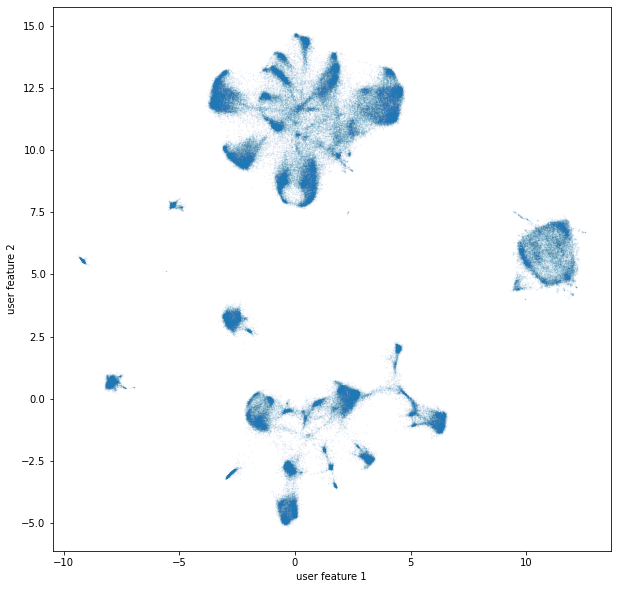

In [58]:
f, ax = plt.subplots(figsize=[10,10])
ax.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1], s=0.1, alpha=0.1)
ax.set(
    #xlim=[-3,7],
    #ylim=[-2, 12],
    xlabel='user feature 1',
    ylabel='user feature 2')